## New_Contributors_of_Commits
This is the reference implementation for [New Contributors of Commits](https://github.com/chaoss/wg-evolution/blob/master/metrics/pull-requests-merge-contributor-new.md),
a metric specified by the
[Evolution Working Group](https://github.com/chaoss/wg-evolution) of the
[CHAOSS project](https://chaoss.community).
This implementation is specific to Git repositories.

Have a look at [README.md](../README.md) to find out how to run this notebook (and others in this directory) as well as to get a better understanding of the purpose of the implementations.

The implementation is described in two parts (see below):

* Class for computing New_Contributors_of_Commits
* An explanatory analysis of the class' functionality

Some more auxiliary information in this notebook:

* Examples of the use of the implementation
* Visualizing the data extracted

As discussed in the [README](../README.md) file, the scripts required to analyze the data fetched by Perceval are located in the `code_df` package. Due to python's import system, to import modules from a package which is not in the current directory, we have to either add the package to `PYTHONPATH` or simply append a `..` to `sys.path`, so that `code_df` can be successfully imported. 

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

from code_df import utils
import code_df.conditions as conditions
from code_df.commit import Commit

%matplotlib inline

In [2]:
class NewContributorsOfCommits(Commit):
    """
    Class for New contributors of commits.
    """

    def compute(self, check_range=(None, None)):
        """
        Count number of new committers who committed between the two dates
        of check range.

        :param check_range: A tuple which represents the start and end date
            when new committers will be considered

        :returns count: the number of new committers who committed
            between the dates of check_range
        """

        self.check_since, self.check_until = check_range

        df = pd.DataFrame(columns=self.df.columns)

        if self.check_since is not None:
            df = self.df[self.df['created_date'] < self.check_since]

        committers_before_check_since = set(df['author'].tolist())

        df_new_committers = self.df['author'][
                    (~self.df['author']
                        .isin(
                            list(committers_before_check_since)))
                ]

        if self.check_since is not None:
            df_new_committers = df_new_committers[
                self.check_since <= self.df['created_date']]

        if self.check_until is not None:
            df_new_committers = df_new_committers[
                self.check_until >= self.df['created_date']]

        count_new_committers = len(df_new_committers.unique())
        return count_new_committers

    def _agg(self, df, period):
        """
        Call an aggregation operation on a DataFrame or Series
        to count the number of new committers in a period when
        compared to the previous period.

        :param df: a pandas DataFrame on which the aggregation will be
            applied.

        :param period: A string which can be any one of the pandas time
            series rules:
            'W': week
            'M': month
            'D': day

        :returns df: The final aggregated DataFrame
        """

        def __new_committers_count(series):
            """
            Aggregation method to count the number of new committers
            per period.

            The set of names of people who committed before the current
            period is stored in old_committers and any new committers
            in the current period whose names are not in old_committers
            are counted.

            :param series: a pandas DataFrame on which the aggregation will be
                applied.

            :param period: A string which can be any one of the pandas time
                series rules:
                'W': week
                'M': month
                'D': day

            :returns count: The number of new committers
            """
            if len(series) > 0:
                old_committers = \
                    set(
                        self.df['author'][
                            self.df['created_date'] < series.index[0]]
                        .tolist())

                count = len(series[~series.isin(list(old_committers))]
                            .unique())
                old_committers.update(series.tolist())
                return count

            else:
                return 0

        df = df.resample(period)['author'].agg([__new_committers_count])
        return df


## Performing the Analysis
Using the above class, we can perform several kinds of analysis on the JSON data file, fetched by Perceval. 

At its most basic, the `NewContributorsOfCommits` class can be used to get the number of contributors over the entire interval for which commits are considered, that is, all commits that lie between the `since` and `until` dates passed while creating an object for the above class.

The `check_since` and `check_until` arguments are slightly different from `since` and `until`. While the latter talk about what commits in the data are even considered, `check_since` and `check_until` give us a range in which we actively look for new contributors of commits --- those who had not committed before `check_since`.

### Counting the total number of committers
We pass the data of the JSON file as a list to NewContributorsOfCommits to start off. 

In [3]:
items = utils.read_json_file('../git-commits.json')

Let's use the `compute` method to count the total number of valid commits made. First, we will do it without passing any `since` and `until` dates as well as no `check_since` and `check_until`. In the class above, we can see that if either of `check_since` or `check_until` are `None`, they are assigned the  corresponding value of `since` or `until`. What this means is that when no values are passed for `check_range`, which is the tuple with `check_since` and `check_until` as elements, every contributor to make a commit is a new contributor and hence, we get the total number of unique contributors between `since` and `until`. 

In [4]:
new_committers = NewContributorsOfCommits(items)
print("The total number of new committers is {}.".format(new_committers.compute()))

The total number of new committers is 29.


### Counting contributors in a specific range

Now, lets give the `check_range` tuple as a subset of the `date_range` tuple, which has `since` and `until` as its elements. Lets pass 2018-01-01 and 2018-07-01 for `date_range`. Let `check_range` be between 2018-03-08 and 2018-06-08. 
We'll also add some filters on the number of commits: 
- exclude any commits that work solely on the tests directory
- exclude any commits solely dealing with markdown(.md) and files with the 

In [5]:
date_since = datetime.strptime("2018-01-01", "%Y-%m-%d")
date_until = datetime.strptime("2018-07-01", "%Y-%m-%d")
new_committers_interval = NewContributorsOfCommits(
                                                    items, 
                                                    (date_since, date_until), 
                                                    is_code=[conditions.DirExclude(['tests']),
                                                             conditions.PostfixExclude(['.md', 'COPYING'])])

print("The total number of new committers between 2018-01-01 and 2018-07-01 in the file is {}."    \
                      .format(new_committers_interval.compute()))

The total number of new committers between 2018-01-01 and 2018-07-01 in the file is 10.


## Counting commits over regular time intervals
Using the `time_series` method, it is possible to compute the number of new committers for every month, or for every week. This kind of analysis is useful in finding trends over time, as we will see in the cell below. Let's see the change in lets see the trend in the number of new committers who first committed between the same dates we used above, on a weekly basis: 2018-01-01 and 2018-07-01. We will use the same object we used when working with the dates above: `new_committers_interval`

In [6]:
weekly_df = new_committers_interval.time_series(cols=['author'], period='W')

Lets see what the dataframe returned by `time_series` looks like. As you will notice, the dataframe has rows corresponding to each and every week between the start and end dates. A simple merge between the dataframes of all possible weeks and the commit count dataframe (which would of course, be missing several rows(weeks) where there would be no commits) gave us this output. 

In [7]:
weekly_df

,new_committers
created_date,
2018-01-07,2
2018-01-14,2
2018-01-21,1
2018-01-28,0
2018-02-04,0
2018-02-11,0
2018-02-18,1
2018-02-25,0
2018-03-04,0


Lets plot the dataframe `weekly_df` using matplotlib.pyplot. We use the `seaborn` theme and plot a simple bar plot --- `new_committer` count vs time interval. 

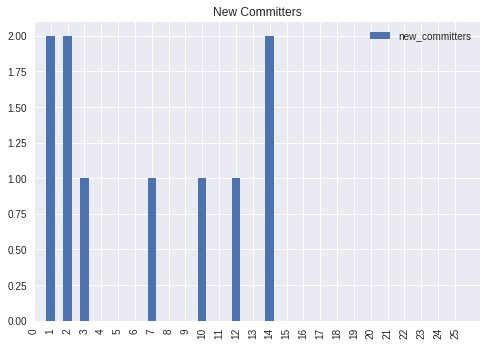

In [8]:
plt.style.use('seaborn')
weekly_df.plot(kind='bar', y='new_committers', use_index=False)
plt.xticks([t.week - 2 for t in weekly_df.index]);
plt.title("New Committers");

The same thing can be done for months, instead of weeks. By passing `month` in place of week, we get a similar dataframe but with only a few rows, due to the larger timescale of each period. 